<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_7926/3065726964.py:22: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(planet_file, sep='\s+', header=None, comment='#')


=== ANÁLISIS DEL SISTEMA NU OCTANTIS (hasta 140 años) ===

1. Graficando evolución del sistema completo (hasta 140 años) con puntos pequeños...
Archivos encontrados: ['./planet1.dat', './planet2.dat']


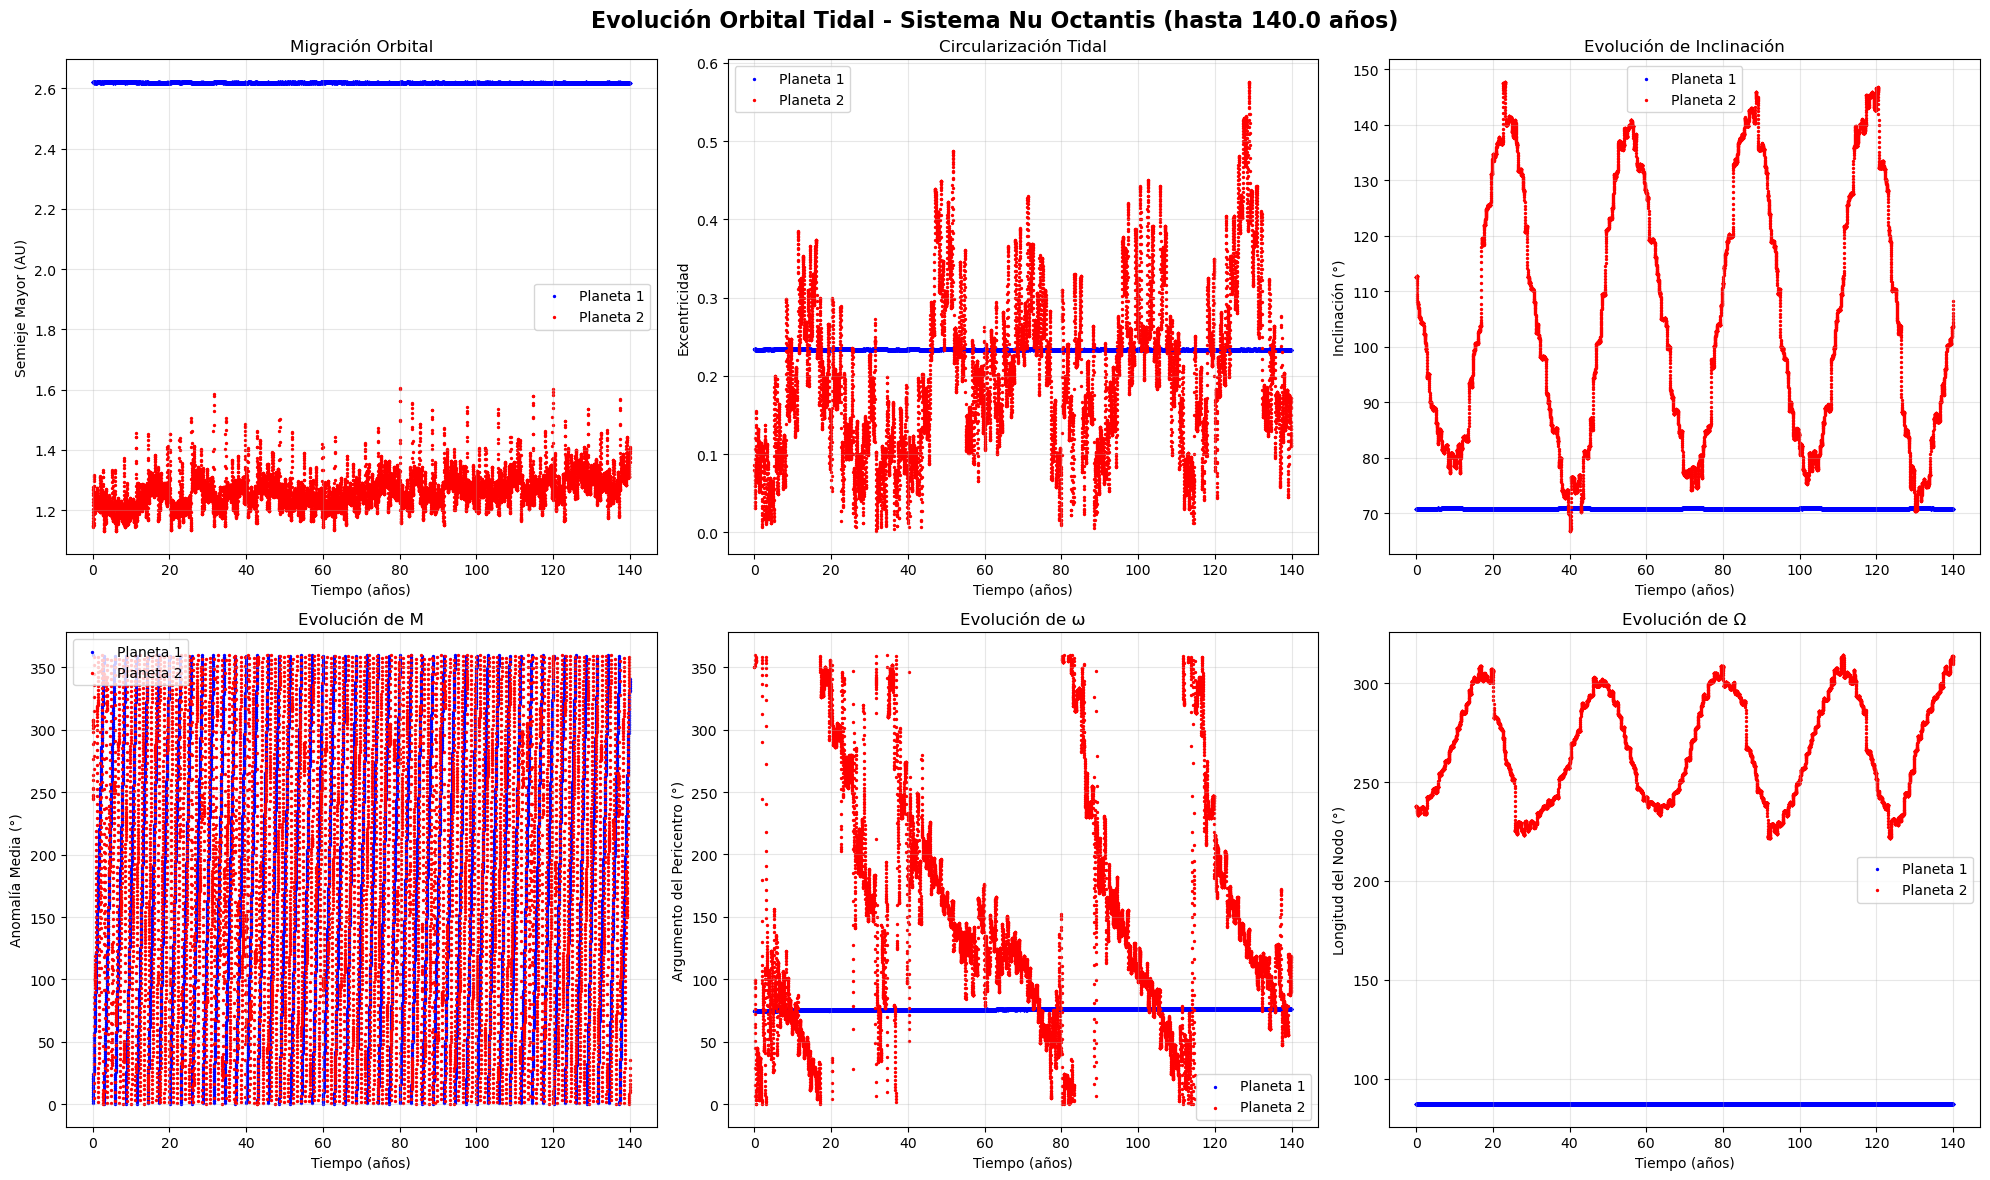


2. Análisis detallado del Planeta 1 (hasta 140 años)...


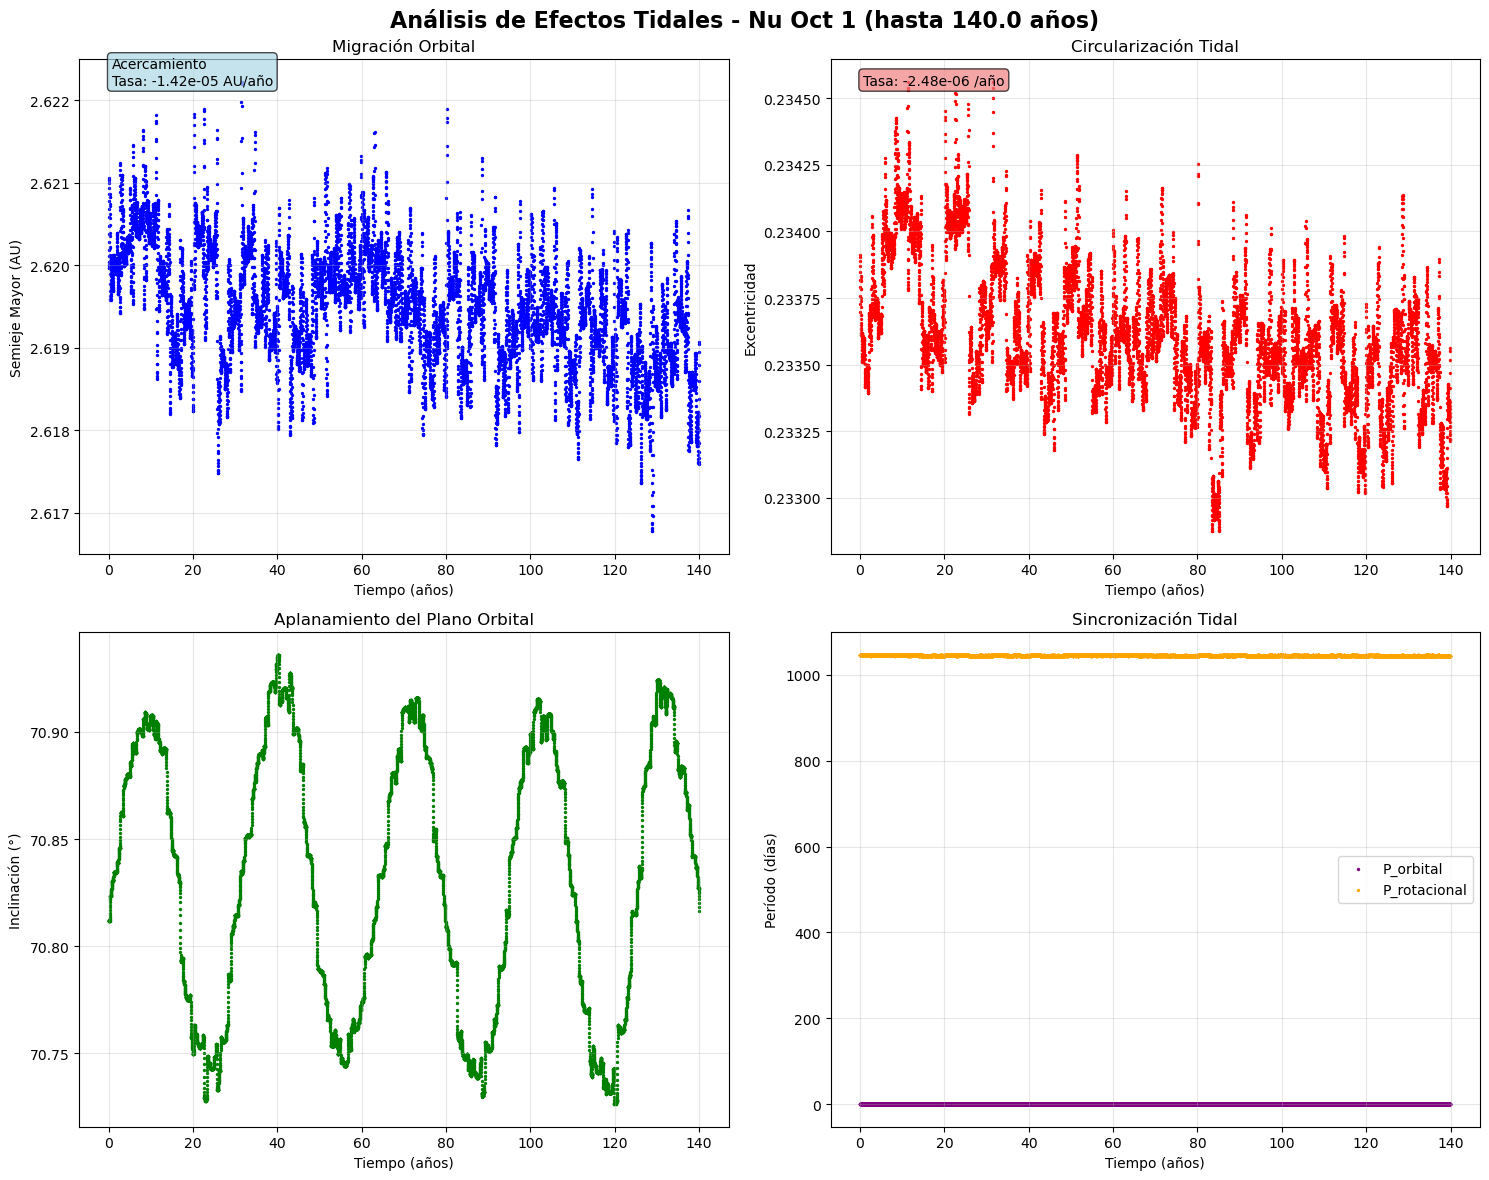

=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===
Archivo: planet1.dat
Tiempo de simulación (filtrado): 1.40e+02 días
                     = 3.83e-01 años

CAMBIOS EN ELEMENTOS ORBITALES:
Δa = -0.001992 AU (tasa: -5.20e-03 AU/año)
Δe = -0.000347    (tasa: -9.05e-04 /año)
Δi = 0.004410 °  (tasa: 1.15e-02 °/año)

ESCALA DE CIRCULARIZACIÓN:
τ_circ ≈ 2.59e+02 años (para e → 0)

ESCALA DE MIGRACIÓN:
τ_mig ≈ 5.04e+02 años (cambio significativo en a)
--------------------------------------------------

2. Análisis detallado del Planeta 2 (hasta 140 años)...


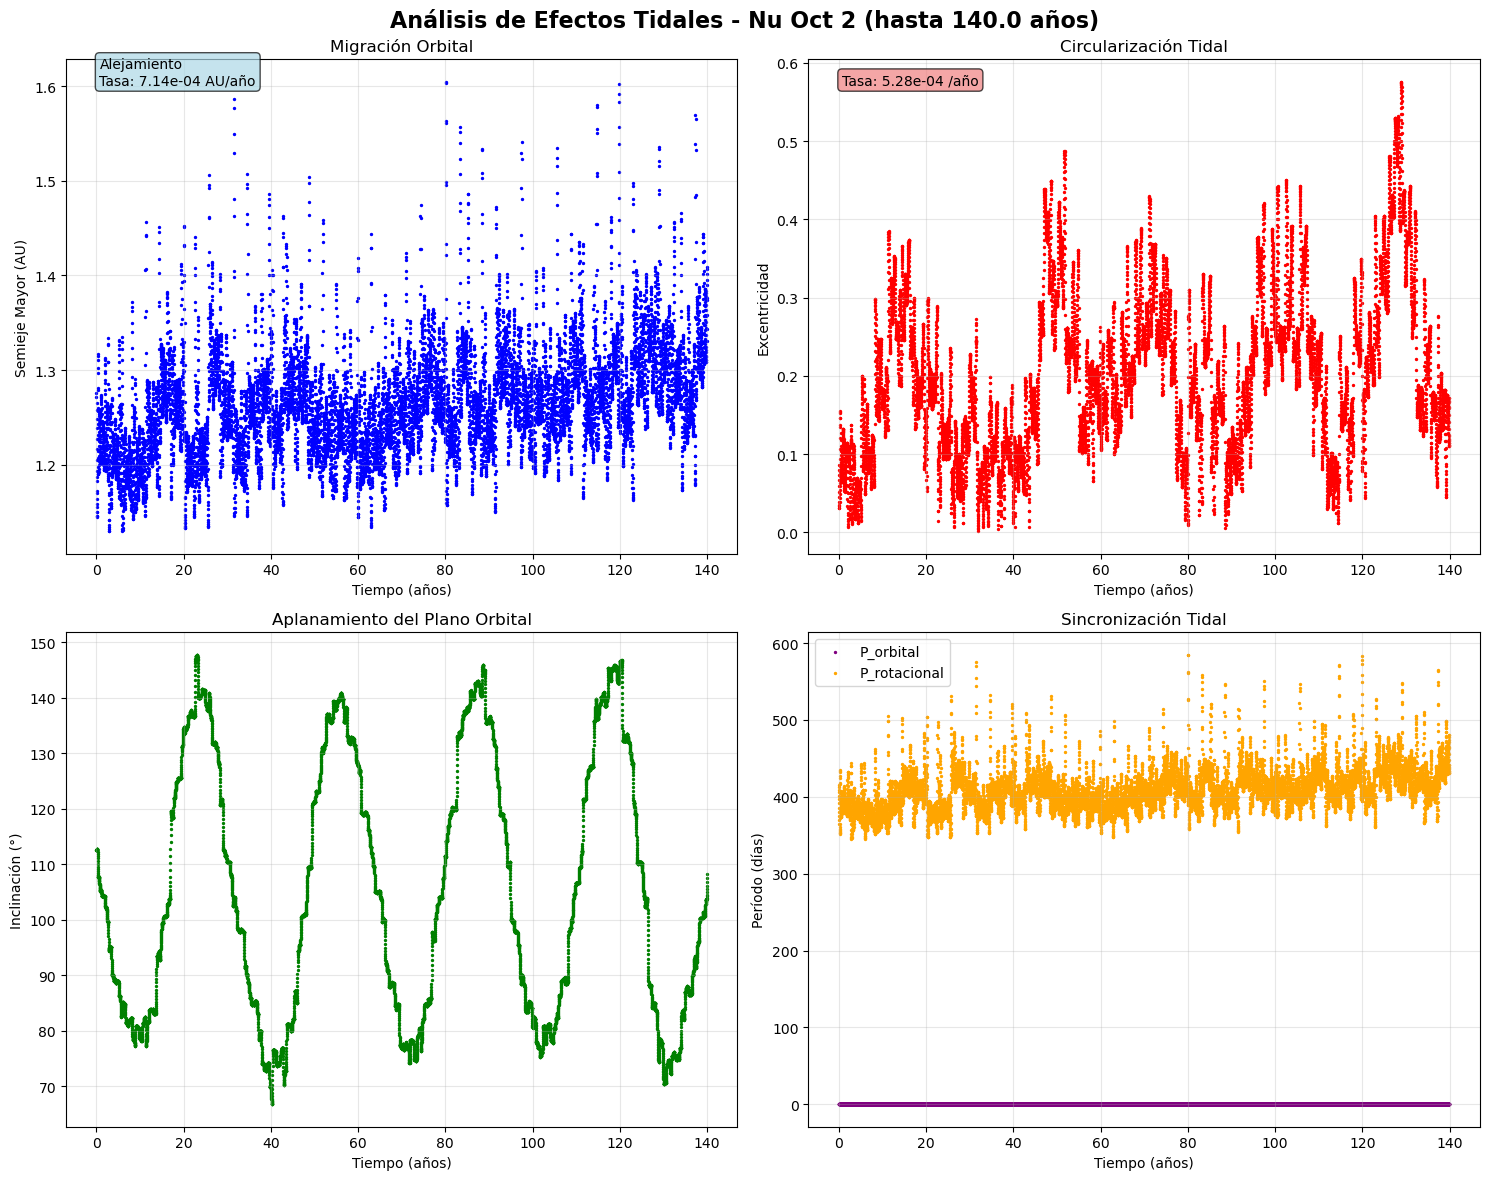

=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===
Archivo: planet2.dat
Tiempo de simulación (filtrado): 1.40e+02 días
                     = 3.83e-01 años

CAMBIOS EN ELEMENTOS ORBITALES:
Δa = 0.100008 AU (tasa: 2.61e-01 AU/año)
Δe = 0.073897    (tasa: 1.93e-01 /año)
Δi = -4.171877 °  (tasa: -1.09e+01 °/año)

ESCALA DE CIRCULARIZACIÓN:
τ_circ ≈ 4.46e-01 años (para e → 0)

ESCALA DE MIGRACIÓN:
τ_mig ≈ 4.89e+00 años (cambio significativo en a)
--------------------------------------------------


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def read_ncorp_planet_data(planet_file):
    """
    Lee datos de un archivo individual de planeta de NCORP
    
    Parameters:
    -----------
    planet_file : str
        Ruta al archivo planetN.dat
        
    Returns:
    --------
    pd.DataFrame : Datos del planeta con columnas nombradas
    """
    try:
        # Leer el archivo (formato: t, a, e, i, M, w, O, [otros parámetros])
        data = pd.read_csv(planet_file, sep='\s+', header=None, comment='#')
        
        # Determinar número de columnas y asignar nombres
        ncols = data.shape[1]
        
        # Columnas básicas según documentación de NCORP
        base_columns = ['t', 'a', 'e', 'i', 'M', 'w', 'O']
        
        # Columnas adicionales posibles según configuración
        additional_columns = ['theta', 'mass', 'radius', 'P_rot_star', 'P_rot_planet', 
                            'P_orbital', 'energy', 'ang_momentum', 'chaos1', 'chaos2', 
                            'chaos3', 'chaos4']
        
        # Asignar columnas según el número disponible
        columns = base_columns + additional_columns[:ncols-len(base_columns)]
        data.columns = columns[:ncols]
        
        return data
        
    except Exception as e:
        print(f"Error leyendo {planet_file}: {e}")
        return None

def plot_nuoct_system(data_dir='.', output_dir='plots', max_years=140.0, marker_size=2):
    """
    Grafica la evolución orbital del sistema Nu Octantis completo
    leyendo archivos planet1.dat, planet2.dat, etc.
    Solo grafica hasta max_years años. Usa puntos muy pequeños en vez de líneas.
    """
    
    # Buscar archivos de planetas
    planet_files = sorted(glob.glob(os.path.join(data_dir, 'planet*.dat')))
    
    if not planet_files:
        print("No se encontraron archivos planet*.dat en el directorio")
        return None
    
    print(f"Archivos encontrados: {planet_files}")
    
    # Leer datos de todos los planetas
    planets_data = {}
    for pfile in planet_files:
        planet_num = os.path.basename(pfile).replace('planet', '').replace('.dat', '')
        data = read_ncorp_planet_data(pfile)
        if data is not None:
            # Convertir tiempo a años
            t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
            data = data.copy()
            data['t_years'] = t_years
            # Filtrar hasta max_years
            data = data[data['t_years'] <= max_years]
            if len(data) > 0:
                planets_data[planet_num] = data
    
    if not planets_data:
        print(f"No hay datos hasta {max_years} años")
        return None
    
    # Crear figura principal
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Evolución Orbital Tidal - Sistema Nu Octantis (hasta {max_years} años)', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    
    # Gráficos para cada elemento orbital
    plot_configs = [
        ('a', 'Semieje Mayor (AU)', 'Migración Orbital', axes[0,0]),
        ('e', 'Excentricidad', 'Circularización Tidal', axes[0,1]),
        ('i', 'Inclinación (°)', 'Evolución de Inclinación', axes[0,2]),
        ('M', 'Anomalía Media (°)', 'Evolución de M', axes[1,0]),
        ('w', 'Argumento del Pericentro (°)', 'Evolución de ω', axes[1,1]),
        ('O', 'Longitud del Nodo (°)', 'Evolución de Ω', axes[1,2])
    ]
    
    for param, ylabel, title, ax in plot_configs:
        plotted = False
        for i, (planet_num, data) in enumerate(planets_data.items()):
            if param in data.columns and len(data) > 0:
                color = colors[i % len(colors)]
                # Usar puntos pequeños en lugar de líneas
                ax.scatter(data['t_years'], data[param], color=color, s=marker_size, label=f'Planeta {planet_num}', rasterized=True)
                plotted = True
        
        ax.set_xlabel('Tiempo (años)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        if plotted:
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No hay datos', transform=ax.transAxes, ha='center')
    
    plt.tight_layout()
    
    # Guardar
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/nuoct_system_evolution_up_to_{int(max_years)}yr_points.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, planets_data

def plot_tidal_effects_detailed(planet_file, planet_name="Nu Oct", output_dir='plots', max_years=140.0, marker_size=2):
    """
    Análisis detallado de efectos tidales para un planeta específico
    Solo hasta max_years años. Grafica puntos muy pequeños.
    """
    
    data = read_ncorp_planet_data(planet_file)
    if data is None:
        return None
    
    # Convertir tiempo a años
    t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
    data = data.copy()
    data['t_years'] = t_years
    data = data[data['t_years'] <= max_years]
    
    if len(data) < 2:
        print(f"No hay suficientes datos en {planet_file} hasta {max_years} años")
        return None
    
    # Crear figura con análisis tidal detallado
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis de Efectos Tidales - {planet_name} (hasta {max_years} años)', fontsize=16, fontweight='bold')
    
    # 1. Migración orbital (semieje mayor) - puntos pequeños
    ax1 = axes[0, 0]
    ax1.scatter(data['t_years'], data['a'], color='b', s=marker_size, rasterized=True)
    ax1.set_xlabel('Tiempo (años)')
    ax1.set_ylabel('Semieje Mayor (AU)')
    ax1.set_title('Migración Orbital')
    ax1.grid(True, alpha=0.3)
    
    # Calcular tendencia
    if len(data) > 1:
        migration_rate = (data['a'].iloc[-1] - data['a'].iloc[0]) / (data['t_years'].iloc[-1] - data['t_years'].iloc[0])
        trend = 'Alejamiento' if migration_rate > 0 else 'Acercamiento'
        ax1.text(0.05, 0.95, f'{trend}\nTasa: {migration_rate:.2e} AU/año', 
                transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 2. Circularización (excentricidad) - puntos pequeños
    ax2 = axes[0, 1]
    ax2.scatter(data['t_years'], data['e'], color='r', s=marker_size, rasterized=True)
    ax2.set_xlabel('Tiempo (años)')
    ax2.set_ylabel('Excentricidad')
    ax2.set_title('Circularización Tidal')
    ax2.grid(True, alpha=0.3)
    
    if len(data) > 1:
        circ_rate = (data['e'].iloc[-1] - data['e'].iloc[0]) / (data['t_years'].iloc[-1] - data['t_years'].iloc[0])
        ax2.text(0.05, 0.95, f'Tasa: {circ_rate:.2e} /año', 
                transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    # 3. Aplanamiento orbital (inclinación) - puntos pequeños
    ax3 = axes[1, 0]
    ax3.scatter(data['t_years'], data['i'], color='g', s=marker_size, rasterized=True)
    ax3.set_xlabel('Tiempo (años)')
    ax3.set_ylabel('Inclinación (°)')
    ax3.set_title('Aplanamiento del Plano Orbital')
    ax3.grid(True, alpha=0.3)
    
    # 4. Período orbital vs tiempo - puntos pequeños
    ax4 = axes[1, 1]
    if 'P_orbital' in data.columns:
        ax4.scatter(data['t_years'], data['P_orbital'], color='purple', s=marker_size, label='P_orbital', rasterized=True)
        if 'P_rot_planet' in data.columns:
            ax4.scatter(data['t_years'], data['P_rot_planet'], color='orange', s=marker_size, label='P_rotacional', rasterized=True)
            ax4.set_title('Sincronización Tidal')
        else:
            ax4.set_title('Evolución del Período Orbital')
        ax4.legend()
    else:
        # Calcular período a partir del semieje mayor (3ra ley de Kepler)
        P_calculated = 365.25 * np.sqrt(data['a']**3)  # días, asumiendo masa solar
        ax4.scatter(data['t_years'], P_calculated, color='purple', s=marker_size, rasterized=True)
        ax4.set_title('Período Orbital (calculado)')
    
    ax4.set_xlabel('Tiempo (años)')
    ax4.set_ylabel('Período (días)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar
    os.makedirs(output_dir, exist_ok=True)
    planet_name_clean = planet_name.replace(' ', '_')
    plt.savefig(f'{output_dir}/tidal_analysis_{planet_name_clean}_up_to_{int(max_years)}yr_points.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, data

def analyze_tidal_timescales(planet_file, max_years=140.0):
    """
    Calcula escalas temporales características de los efectos tidales
    Solo hasta max_years años.
    """
    
    data = read_ncorp_planet_data(planet_file)
    if data is None:
        return None
    
    # Convertir tiempo a años y filtrar
    t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
    data = data.copy()
    data['t_years'] = t_years
    data = data[data['t_years'] <= max_years]
    
    if data is None or len(data) < 2:
        print(f"No hay suficientes datos en {planet_file} hasta {max_years} años")
        return None
    
    print("=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===")
    print(f"Archivo: {planet_file}")
    print(f"Tiempo de simulación (filtrado): {data['t'].iloc[-1] - data['t'].iloc[0]:.2e} días")
    print(f"                     = {(data['t'].iloc[-1] - data['t'].iloc[0])/365.25:.2e} años")
    
    # Cambios en elementos orbitales
    delta_a = data['a'].iloc[-1] - data['a'].iloc[0]
    delta_e = data['e'].iloc[-1] - data['e'].iloc[0]
    delta_i = data['i'].iloc[-1] - data['i'].iloc[0]
    
    dt_years = (data['t'].iloc[-1] - data['t'].iloc[0]) / 365.25
    
    print(f"\nCAMBIOS EN ELEMENTOS ORBITALES:")
    print(f"Δa = {delta_a:.6f} AU (tasa: {delta_a/dt_years:.2e} AU/año)")
    print(f"Δe = {delta_e:.6f}    (tasa: {delta_e/dt_years:.2e} /año)")
    print(f"Δi = {delta_i:.6f} °  (tasa: {delta_i/dt_years:.2e} °/año)")
    
    # Estimación de escalas temporales
    if abs(delta_e/dt_years) > 1e-15:
        t_circ = abs(data['e'].iloc[0] / (delta_e/dt_years))
        print(f"\nESCALA DE CIRCULARIZACIÓN:")
        print(f"τ_circ ≈ {t_circ:.2e} años (para e → 0)")
    
    if abs(delta_a/dt_years) > 1e-15:
        t_mig = abs(data['a'].iloc[0] / (delta_a/dt_years))
        print(f"\nESCALA DE MIGRACIÓN:")
        print(f"τ_mig ≈ {t_mig:.2e} años (cambio significativo en a)")

# Ejemplo de uso adaptado a tus archivos
if __name__ == "__main__":
    
    print("=== ANÁLISIS DEL SISTEMA NU OCTANTIS (hasta 140 años) ===")
    
    # Graficar todo el sistema hasta 140 años con puntos muy pequeños
    print("\n1. Graficando evolución del sistema completo (hasta 140 años) con puntos pequeños...")
    fig_system, planets_data = plot_nuoct_system(max_years=140.0, marker_size=2)
    
    # Análisis detallado de cada planeta hasta 140 años
    planet_files = glob.glob('planet*.dat')
    for pfile in planet_files:
        planet_num = pfile.replace('planet', '').replace('.dat', '')
        print(f"\n2. Análisis detallado del Planeta {planet_num} (hasta 140 años)...")
        
        fig_detail_data = plot_tidal_effects_detailed(pfile, f"Nu Oct {planet_num}", max_years=140.0, marker_size=2)
        analyze_tidal_timescales(pfile, max_years=140.0)
        print("-" * 50)

In [5]:
import os

In [6]:
# Acá guardo todos los graficos generados como PNG en la carpeta 'plots'

# Crear la carpeta 'plots' si no existe
if not os.path.exists('plots'):
    os.makedirs('plots')

# Guardar la figura del sistema completo
if 'fig_system' in locals():
    fig_system.savefig('plots/nuoct_system_evolution.png', dpi=300, bbox_inches='tight')

# Guardar las figuras detalladas de cada planeta
for planet_num in planets_data.keys():
    fig_name = f'plots/tidal_analysis_Nu_Oct_{planet_num}.png'
    if os.path.exists(fig_name):
        print(f'Figura detallada del Planeta {planet_num} guardada en {fig_name}')


Figura detallada del Planeta 1 guardada en plots/tidal_analysis_Nu_Oct_1.png
Figura detallada del Planeta 2 guardada en plots/tidal_analysis_Nu_Oct_2.png
